In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pytorch_lightning as pl
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet

In [2]:
# Paths
MODELS_DIR = Path("../models")
PREDICTIONS_DIR = Path("../predictions")
PREDICTIONS_DIR.mkdir(exist_ok=True)

# Assets to evaluate
ASSETS = ["AAPL", "IBEX35", "MSFT", "NASDAQ", "S&P500"]

# Matplotlib style
plt.style.use("seaborn-v0_8-darkgrid")

In [3]:
def inverse_transform(scaler_path, data):
    # Inverse transform scaled data using a saved scaler
    scaler = joblib.load(scaler_path)
    return scaler.inverse_transform(np.array(data).reshape(-1, 1)).flatten()

In [4]:
# Function to evaluate predictions
def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [5]:
# Load models, make predictions and evaluate
results = []

for asset in ASSETS:
    print(f"\n=== Evaluating LSTM for {asset} ===")

    # Load predictions file
    df_pred = pd.read_csv(MODELS_DIR / f"predictions_{asset}.csv")

    # Inverse transform if predictions are scaled
    y_true_inv = inverse_transform(MODELS_DIR / f"scaler_y_{asset}.pkl", df_pred["Actual_Volatility"])
    y_pred_inv = inverse_transform(MODELS_DIR / f"scaler_y_{asset}.pkl", df_pred["Predicted_Volatility"])

    # Evaluate
    rmse, mae, r2 = evaluate_predictions(y_true_inv, y_pred_inv)
    print(f"{asset} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Save unscaled predictions
    pd.DataFrame({
        "date": df_pred["Date"],
        "y_true": y_true_inv,
        "y_pred": y_pred_inv
    }).to_csv(PREDICTIONS_DIR / f"predictions_lstm_{asset}.csv", index=False)
    print(f"Dataset saved in predictions_lstm_{asset}.csv")

    # Append metrics
    results.append({
        "asset": asset,
        "RMSE_LSTM": rmse,
        "MAE_LSTM": mae,
        "R2_LSTM": r2
    })


=== Evaluating LSTM for AAPL ===
AAPL → RMSE: 0.0168, MAE: 0.0103, R²: 0.6343
Dataset saved in predictions_lstm_AAPL.csv

=== Evaluating LSTM for IBEX35 ===
IBEX35 → RMSE: 0.0048, MAE: 0.0035, R²: 0.6150
Dataset saved in predictions_lstm_IBEX35.csv

=== Evaluating LSTM for MSFT ===
MSFT → RMSE: 0.0111, MAE: 0.0074, R²: 0.6317
Dataset saved in predictions_lstm_MSFT.csv

=== Evaluating LSTM for NASDAQ ===
NASDAQ → RMSE: 0.0093, MAE: 0.0056, R²: 0.6909
Dataset saved in predictions_lstm_NASDAQ.csv

=== Evaluating LSTM for S&P500 ===
S&P500 → RMSE: 0.0065, MAE: 0.0040, R²: 0.7207
Dataset saved in predictions_lstm_S&P500.csv


In [6]:
# Save metrics and show summary
metrics_df = pd.DataFrame(results)
metrics_df.to_csv(PREDICTIONS_DIR / "metrics_lstm_summary.csv", index=False)
metrics_df

,asset,RMSE_LSTM,MAE_LSTM,R2_LSTM
0,AAPL,0.016830,0.010322,0.634259
1,IBEX35,0.004780,0.003490,0.615035
2,MSFT,0.011099,0.007352,0.631653
3,NASDAQ,0.009321,0.005577,0.690937
4,S&P500,0.006491,0.003953,0.720691


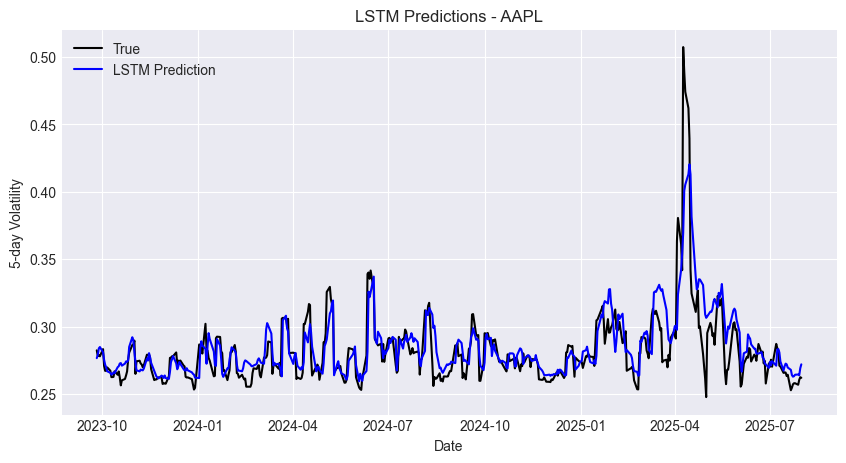

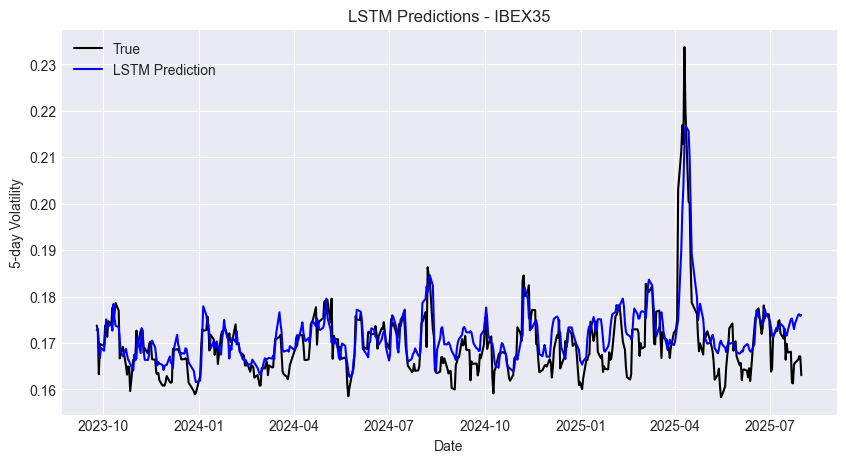

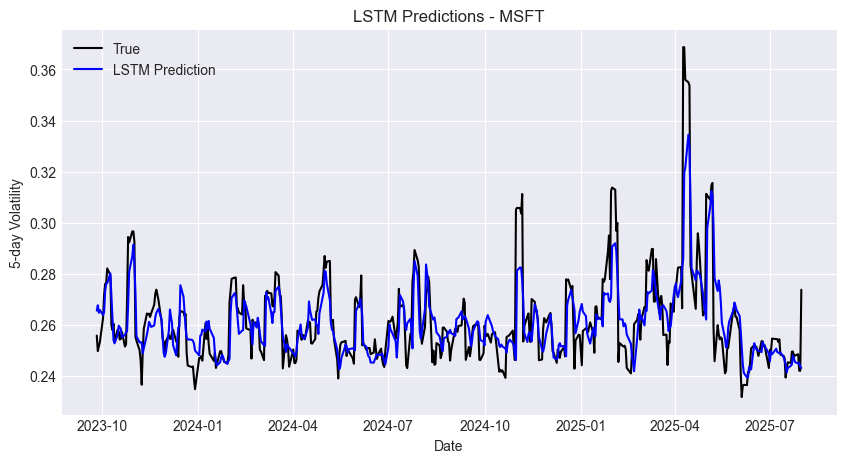

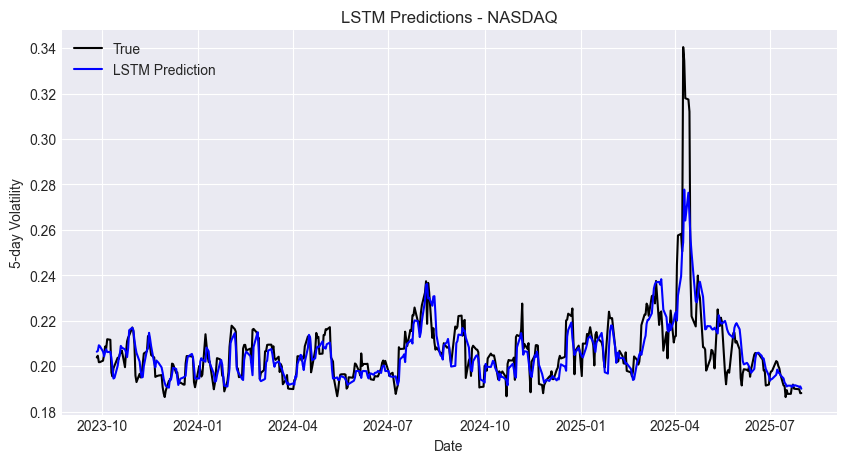

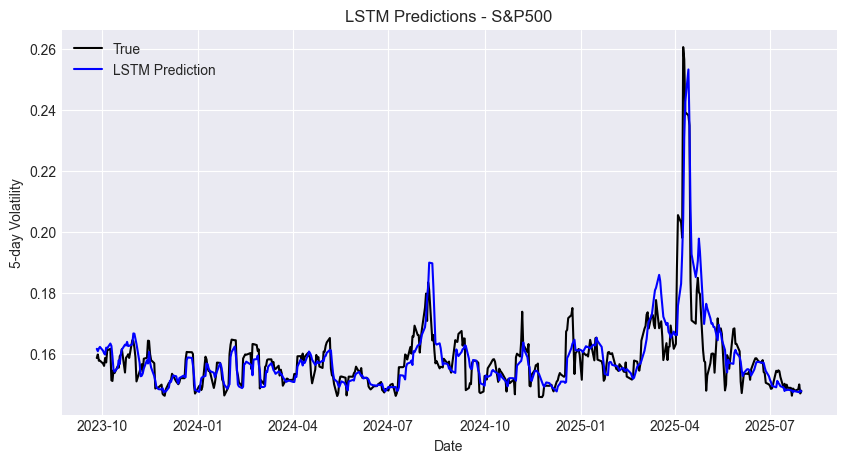

In [7]:
# Plot LSTM predictions
for asset in ASSETS:
    df_pred = pd.read_csv(PREDICTIONS_DIR / f"predictions_lstm_{asset}.csv", parse_dates=["date"])

    plt.figure(figsize=(10, 5))
    plt.plot(df_pred["date"], df_pred["y_true"], label="True", color="black")
    plt.plot(df_pred["date"], df_pred["y_pred"], label="LSTM Prediction", color="blue")
    plt.title(f"LSTM Predictions - {asset}")
    plt.xlabel("Date")
    plt.ylabel("5-day Volatility")
    plt.legend()
    plt.show()